# Image Preprocessing 

In [1]:
from PIL import Image
import glob

image_path = 'omniglot_resized/*/*/'

all_images = glob.glob(image_path + '*')

i = 0

for image_file in all_images:
    im = Image.open(image_file)
    im = im.resize((28,28), resample=Image.LANCZOS)
    im.save(image_file)
    i += 1

    if i % 200 == 0:
        print(i)


200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000
17200
17400
17600
17800
18000
18200
18400
18600
18800
19000
19200
19400
19600
19800
20000
20200
20400
20600
20800
21000
21200
21400
21600
21800
22000
22200
22400
22600
22800
23000
23200
23400
23600
23800
24000
24200
24400
24600
24800
25000
25200
25400
25600
25800
26000
26200
26400
26600
26800
27000
27200
27400
27600
27800
28000
28200
28400
28600
28800
29000
29200
29400
29600
29800
30000
30200
30400
30600
30800
31000
31200
31400
31600
31800
32000
32200
32400


# Imports 

In [3]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.optim.lr_scheduler import StepLR
import torchvision.datasets as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import Sampler

import numpy as np
import os 
import math
import argparse
import random
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt

from PIL import Image
import glob
#import task_generator as tg



# Utilties

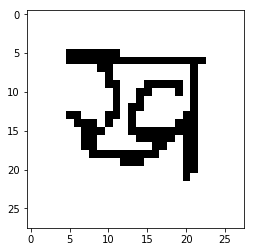

In [11]:
def imshow(img):
    img = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    

sample_img = "omniglot_resized/Sanskrit/character02/0852_01.png"
plt.imshow(Image.open(sample_img))
    

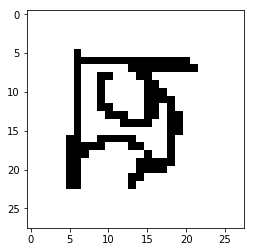

In [12]:
class Rotate(object):
    def __init__(self, angle):
        self.angle = angle
    def __call__(self, x, mode="reflect"):
        x = x.rotate(self.angle)
        return x
    
r = Rotate(90)
plt.imshow(r(Image.open(sample_img)))


In [7]:
#there are 1623 characters in total, so we use 1200 characters to train the network while the rest are used for testing
def omniglot_character_folders():
    data_folder = 'omniglot_resized/'

    character_folders = [os.path.join(data_folder, family, character) \
                for family in os.listdir(data_folder) \
                if os.path.isdir(os.path.join(data_folder, family)) \
                for character in os.listdir(os.path.join(data_folder, family))]
    random.seed(1)
    random.shuffle(character_folders)

    print(len(character_folders))
    num_train = 1200
    metatrain_character_folders = character_folders[:num_train]
    metaval_character_folders = character_folders[num_train:]

    return metatrain_character_folders,metaval_character_folders

train, val = omniglot_character_folders()

#print(train)

#print(val)

1623


In [8]:
class OmniglotTask(object):
    # This function is basically for data generation, its used for training and testing purposes
    # This class is for task generation for both meta training and meta testing.
    def __init__(self, character_folders, num_classes, train_num,test_num):

        self.character_folders = character_folders
        self.num_classes = num_classes
        self.train_num = train_num
        self.test_num = test_num

        class_folders = random.sample(self.character_folders,self.num_classes)
        labels = np.array(range(len(class_folders)))
        labels = dict(zip(class_folders, labels))
        samples = dict()

        self.train_roots = []
        self.test_roots = []
        for c in class_folders:

            temp = [os.path.join(c, x) for x in os.listdir(c)]
            samples[c] = random.sample(temp, len(temp))

            self.train_roots += samples[c][:train_num]
            self.test_roots += samples[c][train_num:train_num+test_num]

        self.train_labels = [labels[self.get_class(x)] for x in self.train_roots]
        self.test_labels = [labels[self.get_class(x)] for x in self.test_roots]

    def get_class(self, sample):
        return os.path.join(*sample.split('/')[:-1])

In [9]:
class FewShotDataset(Dataset):
    # For the dataset loader

    def __init__(self, task, split='train', transform=None, target_transform=None):
        self.transform = transform # Torch operations on the input image
        self.target_transform = target_transform
        self.task = task
        self.split = split
        self.image_roots = self.task.train_roots if self.split == 'train' else self.task.test_roots
        self.labels = self.task.train_labels if self.split == 'train' else self.task.test_labels

    def __len__(self):
        return len(self.image_roots)

    def __getitem__(self, idx):
        raise NotImplementedError("This is an abstract class. Subclass this class for your particular dataset.")

In [10]:
class Omniglot(FewShotDataset):
    # For loading the dataset

    def __init__(self, *args, **kwargs):
        super(Omniglot, self).__init__(*args, **kwargs)

    def __getitem__(self, idx):
        image_root = self.image_roots[idx]
        image = Image.open(image_root)
        image = image.convert('L')
        image = image.resize((28,28), resample=Image.LANCZOS)
        # the above written lanczos is just a way of filtering the image, other possible methods could be bilinear etc
        if self.transform is not None:
            image = self.transform(image)
        label = self.labels[idx]
        if self.target_transform is not None:
            label = self.target_transform(label)
        return image, label

#Balancing code borrowed  
class ClassBalancedSampler(Sampler):
    # TO sample the same number of examples from the c1 classes we want to classify our image into 

    def __init__(self, num_per_class, num_cl, num_inst,shuffle=True):
        self.num_per_class = num_per_class
        self.num_cl = num_cl
        self.num_inst = num_inst
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            batch = [[i+j*self.num_inst for i in torch.randperm(self.num_inst)[:self.num_per_class]] for j in range(self.num_cl)]
        else:
            batch = [[i+j*self.num_inst for i in range(self.num_inst)[:self.num_per_class]] for j in range(self.num_cl)]
        batch = [item for sublist in batch for item in sublist]

        if self.shuffle:
            random.shuffle(batch)
        return iter(batch)

    def __len__(self):
        return 1


def get_data_loader(task, num_per_class=1, split='train',shuffle=True,rotation=0):
    # NOTE: batch size here is # instances PER CLASS
    # Data loader is a crucial part of all networks, it is the way you feed data into the network.
    # It is absolutely mandatory for the network. 
    normalize = transforms.Normalize(mean=[0.92206, 0.92206, 0.92206], std=[0.08426, 0.08426, 0.08426])

    dataset = Omniglot(task,split=split,transform=transforms.Compose([Rotate(rotation),transforms.ToTensor(),normalize]))

    if split == 'train':
        sampler = ClassBalancedSampler(num_per_class, task.num_classes, task.train_num,shuffle=shuffle)
    else:
        sampler = ClassBalancedSampler(num_per_class, task.num_classes, task.test_num,shuffle=shuffle)
    loader = DataLoader(dataset, batch_size=num_per_class*task.num_classes, sampler=sampler)

    return loader


# Relation Network 
The paper mentions a model in which both the images are first put through convolution block and then the features are concatenated to act as an input to the relation network

In [5]:
# Paper Details
# the following configurations have been suggested in the paper 
FEATURE_DIM = 64
RELATION_DIM = 8
CLASS_NUM = 20
SAMPLE_NUM_PER_CLASS = 1
BATCH_NUM_PER_CLASS = 10 #as per paper
EPISODE = 1000000 # It was found that the network actually converged in 30000 iterations, these many iterations might 
#needed for 5shot classification
TEST_EPISODE = 1000 # as per paper
LEARNING_RATE = 10e-3 #as per paper
HIDDEN_UNIT = 8 # as per paper

In [52]:
# The architecture of the network in the paper
# First both the sample image and the image from one of the classes is sent into the network 
# the image features are then concatenated and sent into the relation network
# the relation network ultimately learns a deep distance metric 
class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
         
        self.Block1 = nn.Sequential(
                    nn.Conv2d(1,64,3),
                    nn.BatchNorm2d(64,momentum=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2))
        self.Block2 = nn.Sequential(
                    nn.Conv2d(64,64,3),
                    nn.BatchNorm2d(64,momentum=1),
                    nn.MaxPool2d(2))
        self.Block3 = nn.Sequential(
                    nn.Conv2d(64,64,3,padding=1),
                    nn.BatchNorm2d(64,momentum=1),
                    nn.ReLU(),
                    )
        self.Block4 = nn.Sequential(
                    nn.Conv2d(64,64,3,padding=1),
                    nn.BatchNorm2d(64,momentum=1),
                    nn.ReLU())
        
        
    def forward(self, x):
        out = self.Block1(x)
        out = self.Block2(out)
        out = self.Block3(out)
        out = self.Block4(out)
        
        return out
    
    
    
class RelationNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RelationNetwork, self).__init__()
        self.Block1 = nn.Sequential(
                    nn.Conv2d(128,64,3,padding=1),
                    nn.BatchNorm2d(64,momentum=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2))
        self.Block2 = nn.Sequential(
                    nn.Conv2d(64,64,3,padding=1),
                    nn.BatchNorm2d(64,momentum=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2))
        
        self.fconv1 = nn.Linear(input_size, hidden_size)
        self.fconv2 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out = self.Block1(x)
        out = self.Block2(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fconv1(out))
        out = torch.sigmoid(self.fconv2(out))
        return out
        
        
        
def init_weights(m):  #Can Play with Initializations to check 
    # I have initialized all the blocks with xavier initialization , one form of standard initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(1)
        
    if type(m) == nn.BatchNorm2d:
        m.bias.data.fill_(0.01)
        nn.init.constant_(m.weight,1)
        
        
    if type(m) == nn.Conv2d: 
        m.bias.data.fill_(0.01)
        nn.init.xavier_normal_(m.weight)
       
        
    
    
def main():
    
    train, test = omniglot_character_folders()
    #print("Char Folders: ", train, val)
    
    CNN = CNNEncoder()
    relation_network = RelationNetwork(FEATURE_DIM, RELATION_DIM)
    
    CNN.apply(init_weights)
    relation_network.apply(init_weights)
    
    CNN.cuda()
    relation_network.cuda()
    
    CNN_optim = torch.optim.Adam(CNN.parameters(), lr=10e-3)
    rn_optim = torch.optim.Adam(relation_network.parameters(), lr = 10e-3)
    
    # this is to reduce the Learning rate as per mentioned by the paper
    # the learning rate scheduler could also be changed to something else and played with
    # but in this case the step learning rate was used
    CNN_scheduler = StepLR(CNN_optim, step_size=100000, gamma=0.5)#Check gamma value
    rn_scheduler = StepLR(rn_optim, step_size=100000, gamma=0.5)
    
    
    last_accuracy = 0.0
    
    
    for episode in range(EPISODE):
        
        CNN_scheduler.step(episode)
        rn_scheduler.step(episode)
        
        degrees = random.choice([0,90,180,270])
        task = OmniglotTask(train, CLASS_NUM, SAMPLE_NUM_PER_CLASS, BATCH_NUM_PER_CLASS)
        # the following dataloader are for the training phase 
        # the sample data loader loads one image per class 
        # the batch data loader samples 10 images per class 
        sample_dl = get_data_loader(task, num_per_class=SAMPLE_NUM_PER_CLASS, split="train", shuffle=False, rotation=degrees)
        batch_dl = get_data_loader(task, num_per_class=BATCH_NUM_PER_CLASS, split="test", shuffle=True, rotation=degrees)
    
        samples, sample_labels = sample_dl.__iter__().next()
        batches, batch_labels = batch_dl.__iter__().next()
        
        # 
        sample_features = CNN(Variable(samples).cuda()) # 20x64*5*5
        batch_features = CNN(Variable(batches).cuda()) # 20x64*5*5

        # unsqueezing and repeating is just done so as to make it easy to concatenate them into a single vector
        sample_features_ext = sample_features.unsqueeze(0).repeat(BATCH_NUM_PER_CLASS*CLASS_NUM,1,1,1,1)
        batch_features_ext = batch_features.unsqueeze(0).repeat(SAMPLE_NUM_PER_CLASS*CLASS_NUM,1,1,1,1)
        batch_features_ext = torch.transpose(batch_features_ext,0,1)

        # as mentioned earlier the inputs from the CNNs are concatenated and these act as an input to the relation network
        relation_pairs = torch.cat((sample_features_ext,batch_features_ext),2).view(-1,FEATURE_DIM*2,5,5)
        relations = relation_network(relation_pairs).view(-1,CLASS_NUM)
        
        
        # A mean squared error loss is employed between the labels predicted by the relation network 
        # and the actual labels
        mse = nn.MSELoss().cuda()
        one_hot_labels = Variable(torch.zeros(BATCH_NUM_PER_CLASS*CLASS_NUM, CLASS_NUM).scatter_(1, batch_labels.view(-1,1), 1)).cuda()
        loss = mse(relations,one_hot_labels)
        #print(loss.item())


        # training

        CNN.zero_grad()
        relation_network.zero_grad()

        loss.backward()
        
        # Clipping gradients is just done so as to avoid gradient explosion

        nn.utils.clip_grad_norm_(CNN.parameters(),0.5)
        nn.utils.clip_grad_norm_(relation_network.parameters(),0.5)

        CNN_optim.step()
        rn_optim.step()

        if (episode+1)%100 == 0:
                print("episode:",episode+1,"loss",loss.item())
                
                
                
        if (episode+1)%5000 == 0:

            # test
            print("Testing...")
            total_rewards = 0

            for i in range(TEST_EPISODE):
                degrees = random.choice([0,90,180,270])
                task = OmniglotTask(test,CLASS_NUM,SAMPLE_NUM_PER_CLASS,SAMPLE_NUM_PER_CLASS,)
                sample_dataloader = get_data_loader(task,num_per_class=SAMPLE_NUM_PER_CLASS,split="train",shuffle=False,rotation=degrees)
                test_dataloader = get_data_loader(task,num_per_class=SAMPLE_NUM_PER_CLASS,split="test",shuffle=True,rotation=degrees)

                sample_images,sample_labels = sample_dataloader.__iter__().next()
                test_images,test_labels = test_dataloader.__iter__().next()

               
                sample_features = CNN(Variable(sample_images).cuda()) 
                test_features = CNN(Variable(test_images).cuda()) 

                
                sample_features_ext = sample_features.unsqueeze(0).repeat(SAMPLE_NUM_PER_CLASS*CLASS_NUM,1,1,1,1)
                test_features_ext = test_features.unsqueeze(0).repeat(SAMPLE_NUM_PER_CLASS*CLASS_NUM,1,1,1,1)
                test_features_ext = torch.transpose(test_features_ext,0,1)

                relation_pairs = torch.cat((sample_features_ext,test_features_ext),2).view(-1,FEATURE_DIM*2,5,5)
                relations = relation_network(relation_pairs).view(-1,CLASS_NUM)

                _,predict_labels = torch.max(relations.data,1)
                
                test_c = Variable(test_labels).cuda()

                rewards = [1 if predict_labels[j]==test_c[j] else 0 for j in range(CLASS_NUM)]

                total_rewards += np.sum(rewards)

            test_accuracy = total_rewards/1.0/CLASS_NUM/TEST_EPISODE

            print("test accuracy:",test_accuracy)

            if test_accuracy > last_accuracy:

                # save networks
                torch.save(CNN.state_dict(),str("./models/omniglot_CNN_" + str(CLASS_NUM) +"way_" + str(SAMPLE_NUM_PER_CLASS) +"shot.pkl"))
                torch.save(relation_network.state_dict(),str("./models/omniglot_relation_network_"+ str(CLASS_NUM) +"way_" + str(SAMPLE_NUM_PER_CLASS) +"shot.pkl"))

                print("save networks for episode:",episode)

                last_accuracy = test_accuracy


                
                
if __name__ == '__main__':
    main()
    

1623
episode: 100 loss 0.047234851866960526
episode: 200 loss 0.030134856700897217
episode: 300 loss 0.028716329485177994
episode: 400 loss 0.025335080921649933
episode: 500 loss 0.021182678639888763
episode: 600 loss 0.013566968031227589
episode: 700 loss 0.01777578517794609
episode: 800 loss 0.021663079038262367
episode: 900 loss 0.014451860450208187
episode: 1000 loss 0.01456803735345602
episode: 1100 loss 0.014613676816225052
episode: 1200 loss 0.012531456537544727
episode: 1300 loss 0.012393396347761154
episode: 1400 loss 0.012708797119557858
episode: 1500 loss 0.01445039827376604
episode: 1600 loss 0.009744142182171345
episode: 1700 loss 0.015053289011120796
episode: 1800 loss 0.009002644568681717
episode: 1900 loss 0.014661770313978195
episode: 2000 loss 0.0062833684496581554
episode: 2100 loss 0.010207521729171276
episode: 2200 loss 0.008253704756498337
episode: 2300 loss 0.012623954564332962
episode: 2400 loss 0.007745732553303242
episode: 2500 loss 0.012527993880212307
episod

episode: 19900 loss 0.0031604350078850985
episode: 20000 loss 0.003133546793833375
Testing...
test accuracy: 0.9712999999999999
save networks for episode: 19999
episode: 20100 loss 0.00395806971937418
episode: 20200 loss 0.003600972704589367
episode: 20300 loss 0.009259535931050777
episode: 20400 loss 0.0045841229148209095
episode: 20500 loss 0.007245531305670738
episode: 20600 loss 0.003935899585485458
episode: 20700 loss 0.007002098020166159
episode: 20800 loss 0.0036954539828002453
episode: 20900 loss 0.0035489199217408895
episode: 21000 loss 0.005894646979868412
episode: 21100 loss 0.00503436429426074
episode: 21200 loss 0.007964667864143848
episode: 21300 loss 0.008546394295990467
episode: 21400 loss 0.002242116490378976
episode: 21500 loss 0.006433666683733463
episode: 21600 loss 0.00531307328492403
episode: 21700 loss 0.003937945701181889
episode: 21800 loss 0.0046241492964327335
episode: 21900 loss 0.003856981173157692
episode: 22000 loss 0.010574566200375557
episode: 22100 los

episode: 41000 loss 0.001265936647541821
episode: 41100 loss 0.007452445104718208
episode: 41200 loss 0.00459452997893095
episode: 41300 loss 0.004217158537358046
episode: 41400 loss 0.004831523168832064
episode: 41500 loss 0.0012594233267009258
episode: 41600 loss 0.0019701330456882715
episode: 41700 loss 0.0026809333357959986
episode: 41800 loss 0.0033638791646808386
episode: 41900 loss 0.0024230137933045626
episode: 42000 loss 0.006814518943428993
episode: 42100 loss 0.0010654791258275509
episode: 42200 loss 0.004809497855603695
episode: 42300 loss 0.004863325972110033
episode: 42400 loss 0.006882484070956707
episode: 42500 loss 0.0036198243033140898
episode: 42600 loss 0.002313165692612529
episode: 42700 loss 0.0059229726903140545
episode: 42800 loss 0.0023776746820658445
episode: 42900 loss 0.005758829414844513
episode: 43000 loss 0.005096423905342817
episode: 43100 loss 0.002691881963983178
episode: 43200 loss 0.0024386653676629066
episode: 43300 loss 0.005153115373104811
episode

episode: 60800 loss 0.004791132174432278
episode: 60900 loss 0.0024964509066194296
episode: 61000 loss 0.0035645782481878996
episode: 61100 loss 0.001809322857297957
episode: 61200 loss 0.0056870607659220695
episode: 61300 loss 0.004382009152323008
episode: 61400 loss 0.0031511380802839994
episode: 61500 loss 0.00234976620413363
episode: 61600 loss 0.005619928706437349
episode: 61700 loss 0.005399757996201515
episode: 61800 loss 0.005524763371795416
episode: 61900 loss 0.004333087243139744
episode: 62000 loss 0.002380536636337638
episode: 62100 loss 0.004245559684932232
episode: 62200 loss 0.0028577439952641726
episode: 62300 loss 0.0014786302344873548
episode: 62400 loss 0.001638683839701116
episode: 62500 loss 0.0027501224540174007
episode: 62600 loss 0.0024066490586847067
episode: 62700 loss 0.001766238478012383
episode: 62800 loss 0.001175003475509584
episode: 62900 loss 0.0016342290909960866
episode: 63000 loss 0.004213697277009487
episode: 63100 loss 0.00275651877745986
episode: 

episode: 81600 loss 0.0014361522626131773
episode: 81700 loss 0.0039770039729774
episode: 81800 loss 0.002418926451355219
episode: 81900 loss 0.0028946769889444113
episode: 82500 loss 0.002801464404910803
episode: 82600 loss 0.0013052364811301231
episode: 82700 loss 0.005143740680068731
episode: 82800 loss 0.002751007443293929
episode: 82900 loss 0.0019135529873892665
episode: 83000 loss 0.0004656213568523526
episode: 83100 loss 0.003803742816671729
episode: 83200 loss 0.0006026354967616498
episode: 83300 loss 0.0025244574062526226
episode: 83400 loss 0.0071932231076061726
episode: 83500 loss 0.002729029394686222
episode: 83600 loss 0.0033772208262234926
episode: 83700 loss 0.002214462962001562
episode: 83800 loss 0.0010392317781224847
episode: 83900 loss 0.0026416543405503035
episode: 84000 loss 0.0009444665047340095
episode: 84100 loss 0.0014641335001215339
episode: 84200 loss 0.003792133880779147
episode: 84300 loss 0.0015422403812408447
episode: 84400 loss 0.002560781082138419
epis

episode: 103200 loss 0.005703277885913849
episode: 103300 loss 0.0033875831868499517
episode: 103400 loss 0.001194996410049498
episode: 103500 loss 0.006744151469320059
episode: 103600 loss 0.007216408848762512
episode: 103700 loss 0.0018985128263011575
episode: 103800 loss 0.0011968291364610195
episode: 103900 loss 0.002436029724776745
episode: 104000 loss 0.0022884949576109648
episode: 104100 loss 0.004296845756471157
episode: 104200 loss 0.0011545394081622362
episode: 104300 loss 0.0005619779694825411
episode: 104400 loss 0.0031308578327298164
episode: 104500 loss 0.001549157197587192
episode: 104600 loss 0.001918294234201312
episode: 104700 loss 0.0036254122387617826
episode: 104800 loss 0.0016760444268584251
episode: 104900 loss 0.001190502429381013
episode: 105000 loss 0.0009645461686886847
Testing...
test accuracy: 0.97665
save networks for episode: 104999
episode: 105100 loss 0.003252337919548154
episode: 105200 loss 0.0036457707174122334
episode: 105300 loss 0.0030024282168596

episode: 123200 loss 0.0017005640547722578
episode: 123300 loss 0.0016097989864647388
episode: 123400 loss 0.0021449585910886526
episode: 123500 loss 0.0032073736656457186
episode: 123600 loss 0.001743695349432528
episode: 123700 loss 0.0014129497576504946
episode: 123800 loss 0.0014133434742689133
episode: 123900 loss 0.003091234713792801
episode: 124000 loss 0.004821952898055315
episode: 124100 loss 0.0017952495254576206
episode: 124200 loss 0.0024402132257819176
episode: 124300 loss 0.003136557526886463
episode: 124400 loss 0.0026673278771340847
episode: 124500 loss 0.0011147217592224479
episode: 124600 loss 0.003745941910892725
episode: 124700 loss 0.0012038099812343717
episode: 124800 loss 0.0014182967133820057
episode: 124900 loss 0.0009939788142219186
episode: 125000 loss 0.0031475042924284935
Testing...
test accuracy: 0.97485
episode: 125100 loss 0.0008845809497870505
episode: 125200 loss 0.005083675961941481
episode: 125300 loss 0.0008472389308735728
episode: 125400 loss 0.001

episode: 142100 loss 0.002586107701063156
episode: 142200 loss 0.0019384078914299607
episode: 142300 loss 0.0017204718897119164
episode: 142400 loss 0.003759362269192934
episode: 142500 loss 0.005493117496371269
episode: 142600 loss 0.0017122389981523156
episode: 142700 loss 0.004199619870632887
episode: 142800 loss 0.0024060350842773914
episode: 142900 loss 0.00839728768914938
episode: 143000 loss 0.001638691290281713
episode: 143100 loss 0.0018368426244705915
episode: 143200 loss 0.007329759653657675
episode: 143300 loss 0.0004225803422741592
episode: 143400 loss 0.007474385667592287
episode: 143500 loss 0.0027813741471618414
episode: 143600 loss 0.004363414365798235
episode: 143700 loss 0.0014045890420675278
episode: 143800 loss 0.0013234734069555998
episode: 143900 loss 0.008170398883521557
episode: 144000 loss 0.0015117865987122059
episode: 144100 loss 0.0006318872910924256
episode: 144200 loss 0.001698851934634149
episode: 144300 loss 0.004957057069987059
episode: 144400 loss 0.0

episode: 161000 loss 0.002396402880549431
episode: 161100 loss 0.0005468508461490273
episode: 161200 loss 8.312408317578956e-05
episode: 161300 loss 0.0034045488573610783
episode: 161400 loss 0.0006925187190063298
episode: 161500 loss 0.002968934364616871
episode: 161600 loss 0.0031813455279916525
episode: 161700 loss 0.0016221338883042336
episode: 161800 loss 0.0029584330040961504
episode: 161900 loss 0.0006204807432368398
episode: 162000 loss 0.003595079993829131
episode: 162100 loss 0.001850450411438942
episode: 162200 loss 0.0009646399412304163
episode: 162300 loss 0.0005431697936728597
episode: 162400 loss 0.0006269187433645129
episode: 162500 loss 0.001706856768578291
episode: 162600 loss 0.004599534906446934
episode: 162700 loss 0.003903190139681101
episode: 162800 loss 0.0013861972838640213
episode: 162900 loss 0.0006147852400317788
episode: 163000 loss 0.0012598932953551412
episode: 163100 loss 0.0005196424899622798
episode: 163200 loss 0.0011801327345892787
episode: 163300 lo

episode: 179900 loss 0.002623035339638591
episode: 180000 loss 0.002521525602787733
Testing...
test accuracy: 0.97765
save networks for episode: 179999
episode: 180100 loss 0.0004214684886392206
episode: 180200 loss 0.001724366215057671
episode: 180300 loss 0.0019271713681519032
episode: 180400 loss 0.002355111762881279
episode: 180500 loss 0.001673226710408926
episode: 180600 loss 0.0006056947750039399
episode: 180700 loss 0.0032405017409473658
episode: 180800 loss 0.0016091050347313285
episode: 180900 loss 0.0006583508220501244
episode: 181000 loss 0.0014028511941432953
episode: 181100 loss 0.0028104055672883987
episode: 181200 loss 0.003142253728583455
episode: 181300 loss 0.001034010318107903
episode: 181400 loss 0.0074292514473199844
episode: 181500 loss 0.0010719895362854004
episode: 181600 loss 0.001885092817246914
episode: 181700 loss 0.0013103971723467112
episode: 181800 loss 0.0015421095304191113
episode: 181900 loss 0.0016297606052830815
episode: 182000 loss 0.00476043252274

episode: 198700 loss 0.0017915357602760196
episode: 198800 loss 0.0028289484325796366
episode: 198900 loss 0.0021278602071106434
episode: 199000 loss 0.0017096094088628888
episode: 199100 loss 0.005701120477169752
episode: 199200 loss 0.001019527087919414
episode: 199300 loss 0.0041501689702272415
episode: 199400 loss 0.0072153061628341675
episode: 199500 loss 0.004387089516967535
episode: 199600 loss 0.0012936305720359087
episode: 199700 loss 0.0010462466161698103
episode: 199800 loss 0.002278674393892288
episode: 199900 loss 0.0003534160496201366
episode: 200000 loss 0.0012611363781616092
Testing...
test accuracy: 0.9751000000000001
episode: 200100 loss 0.0018807188607752323
episode: 200200 loss 0.003198671853169799
episode: 200300 loss 0.0024924566969275475
episode: 200400 loss 0.0033463481813669205
episode: 200500 loss 0.0003950243699364364
episode: 200600 loss 0.0004782359173987061
episode: 200700 loss 0.0036391715984791517
episode: 200800 loss 0.0004679980338551104
episode: 20090

episode: 217500 loss 0.0018517456483095884
episode: 217600 loss 0.0008744759252294898
episode: 217700 loss 0.0028365724720060825
episode: 217800 loss 0.002182930940762162
episode: 217900 loss 0.0010385253699496388
episode: 218000 loss 0.0008123042644001544
episode: 218100 loss 0.004565272480249405
episode: 218200 loss 0.001224196283146739
episode: 218300 loss 0.0006110927788540721
episode: 218400 loss 0.0005480487016029656
episode: 218500 loss 0.0012648745905607939
episode: 218600 loss 0.0002584063622634858
episode: 218700 loss 0.0005475522484630346
episode: 218800 loss 0.000404549267841503
episode: 218900 loss 0.0019900044426321983
episode: 219000 loss 0.00025349168572574854
episode: 219100 loss 0.0006219457718543708
episode: 219200 loss 0.0006581099005416036
episode: 219300 loss 0.005131188780069351
episode: 219400 loss 0.0016359462169930339
episode: 219500 loss 0.0024913055822253227
episode: 219600 loss 0.0026766026858240366
episode: 219700 loss 8.776049071457237e-05
episode: 219800

episode: 236400 loss 0.001567279570735991
episode: 236500 loss 0.000442914548330009
episode: 236600 loss 0.0009183146175928414
episode: 236700 loss 0.0010776123963296413
episode: 236800 loss 0.004895435180515051
episode: 236900 loss 7.711066427873448e-05
episode: 237000 loss 0.0010944779496639967
episode: 237100 loss 0.0006863657617941499
episode: 237200 loss 0.0019849759992212057
episode: 237300 loss 0.0009298364166170359
episode: 237400 loss 0.0052685728296637535
episode: 237500 loss 0.007211698219180107
episode: 237600 loss 0.001685930066742003
episode: 237700 loss 0.0021440458949655294
episode: 237800 loss 0.004587043076753616
episode: 237900 loss 0.003210752736777067
episode: 238000 loss 0.0019583599641919136
episode: 238100 loss 0.001773298135958612
episode: 238200 loss 0.0010233387583866715
episode: 238300 loss 0.002440371783450246
episode: 238400 loss 0.003545432584360242
episode: 238500 loss 0.006111844442784786
episode: 238600 loss 0.0014837051276117563
episode: 238700 loss 0

episode: 255300 loss 0.0011764724040403962
episode: 255400 loss 0.0015113366534933448
episode: 255500 loss 0.00227325945161283
episode: 255600 loss 0.0010332622332498431
episode: 255700 loss 0.0019342056475579739
episode: 255800 loss 0.001841467572376132
episode: 255900 loss 0.005370073951780796
episode: 256000 loss 0.0031005998607724905
episode: 256100 loss 0.002036098623648286
episode: 256200 loss 0.0008074712823145092
episode: 256300 loss 0.0008453559130430222
episode: 256400 loss 0.0017344048246741295
episode: 256500 loss 0.0006982578197494149
episode: 256600 loss 0.0005291170091368258
episode: 256700 loss 0.007397657260298729
episode: 256800 loss 0.0012691427255049348
episode: 256900 loss 0.0024177751038223505
episode: 257000 loss 0.0055042169988155365
episode: 257100 loss 0.0017687760991975665
episode: 257200 loss 0.0049724397249519825
episode: 257300 loss 0.0026441351510584354
episode: 257400 loss 0.0018694371683523059
episode: 257500 loss 0.0010062482906505466
episode: 257600 l

episode: 274200 loss 0.0012547418009489775
episode: 274300 loss 0.002076364355161786
episode: 274400 loss 0.002962894504889846
episode: 274500 loss 0.0008321076747961342
episode: 274600 loss 0.0014132686192169785
episode: 274700 loss 0.004522978328168392
episode: 274800 loss 0.0043633379973471165
episode: 274900 loss 0.002373587805777788
episode: 275000 loss 0.0008865187992341816
Testing...
test accuracy: 0.97335
episode: 275100 loss 0.0018020691350102425
episode: 275200 loss 0.000678369658999145
episode: 275300 loss 0.0012134065618738532
episode: 275400 loss 0.0007699879934079945
episode: 275500 loss 0.0069948360323905945
episode: 275600 loss 0.0007757736602798104
episode: 275700 loss 0.00029511464526876807
episode: 275800 loss 0.006005328614264727
episode: 275900 loss 0.0022086072713136673
episode: 276000 loss 0.0005212252726778388
episode: 276100 loss 0.004327872768044472
episode: 276200 loss 0.00027582005714066327
episode: 276300 loss 0.0042173368856310844
episode: 276400 loss 0.00

episode: 293100 loss 0.0007082975935190916
episode: 293200 loss 0.006732705980539322
episode: 293300 loss 0.0020717307925224304
episode: 293400 loss 0.0006972856353968382
episode: 293500 loss 0.0005798609927296638
episode: 293600 loss 0.004050427582114935
episode: 293700 loss 0.0058107441291213036
episode: 293800 loss 0.0019281132845208049
episode: 293900 loss 0.0006938896258361638
episode: 294000 loss 0.0016063271323218942
episode: 294100 loss 0.0008825035765767097
episode: 294200 loss 0.002404933562502265
episode: 294300 loss 0.001491581555455923
episode: 294400 loss 0.0017753159627318382
episode: 294500 loss 0.0016951939323917031
episode: 294600 loss 0.001120901433750987
episode: 294700 loss 0.00047345992061309516
episode: 294800 loss 0.005504949484020472
episode: 294900 loss 0.0008279943722300231
episode: 295000 loss 0.0015746642602607608
Testing...
test accuracy: 0.9748
episode: 295100 loss 0.000539676402695477
episode: 295200 loss 0.0008454846683889627
episode: 295300 loss 0.0010

episode: 312000 loss 0.0032273149117827415
episode: 312100 loss 0.0007113706087693572
episode: 312200 loss 0.0010335457045584917
episode: 312300 loss 0.003300800221040845
episode: 312400 loss 0.0004554123734124005
episode: 312500 loss 0.0003500702150631696
episode: 312600 loss 0.0011427635326981544
episode: 312700 loss 0.001905030687339604
episode: 312800 loss 0.0014625746989622712
episode: 312900 loss 0.00026589201297611
episode: 313000 loss 0.001239100587554276
episode: 313100 loss 0.0013364098267629743
episode: 313200 loss 0.006050392985343933
episode: 313300 loss 0.0004062372026965022
episode: 313400 loss 0.0008621763554401696
episode: 313500 loss 0.00458547193557024
episode: 313600 loss 0.0006780016701668501
episode: 313700 loss 0.00020123629656154662
episode: 313800 loss 0.001223309081979096
episode: 313900 loss 0.00046477053547278047
episode: 314000 loss 0.0011934377253055573
episode: 314100 loss 0.0008283986244350672
episode: 314200 loss 0.0013150193262845278
episode: 314300 lo

KeyboardInterrupt: 


### The Test Accuracy of the model is : 97.49%